## LOAD LIBRARIES

In [462]:
import pandas as pd
import requests
import csv
import datetime
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.pyplot as plt

In [463]:
from google.colab import drive
drive.mount('/content/drive/')
%ls
%cd ~/../content/drive/MyDrive/BDP


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
BESS.csv    data_BESS.csv  main_2.ipynb  raw_data.csv
BESS.ipynb  data.csv       main.ipynb    temperature_data.csv
/content/drive/MyDrive/BDP


# EXTRACT

### I. Read the CSV file into the selected workspace; <br> II.Retrieve and convert the timestamp.

In [464]:
df = pd.read_csv('data_BESS.csv',index_col=0)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature
time,,,,,,,,,,,,
2022-02-21 00:01:00+00:00,0.0,0.935,0.0,0.0,0.0,0.0,0.613942,0.632212,0.595433,0.0,0.267385,0.638462
2022-02-21 00:02:00+00:00,0.0,0.935,0.0,0.0,0.0,0.0,0.613942,0.632212,0.595433,0.0,0.278923,0.638462
2022-02-21 00:03:00+00:00,0.0,0.935,0.0,0.0,0.0,0.0,0.615385,0.632212,0.595433,0.0,0.282769,0.637019
2022-02-21 00:04:00+00:00,0.0,0.935,0.0,0.0,0.0,0.0,0.615385,0.633894,0.595433,0.0,0.294308,0.635337
2022-02-21 00:05:00+00:00,0.0,0.935,0.0,0.0,0.0,0.0,0.615385,0.633894,0.596875,0.0,0.304769,0.635337


# TRANSFORM

### III. Find out what is the sampling of the data;

In [465]:
sampling_time = df.index.to_series().diff()

sampling_time_check = df.index[1] - df.index[0] 

print(f'The sampling time of the data is {sampling_time[1]}')
##print(sampling_time_check)

The sampling time of the data is 0 days 00:01:00


### IV. Resample to uniform sampling and find a reasonable approach to aggregate/interpolate data

#### Check if a dataset contains missing NaN values.

In [466]:
df.isna().sum()

Active Power Setpoint                        0
SOC                                          0
HVAC Battery part Circulation Fan V1         0
HVAC Battery part heating                    0
HVAC Battery part cooling                    0
Battery part Fan Vb1 Feedback                0
Avg. Cell Temperature                        0
Max. Cell Temperatue                         0
Min. Cell Temperature                        0
String Power                                 0
Outside Temperature                     101330
Ambient Temperature                          0
dtype: int64

#### Check for inconsistencies in the sampling time

In [467]:
def check_sampling_time_period(df, sampling_time):
       sampling_time_seconds = sampling_time.total_seconds()
       missing_rows = []

# Loop through the data to check for inconsistencies in the sampling time
       for i in range(1, len(df)): # changed the range to start at 1
              current_time = df.index[i]
              previous_time = df.index[i-1]
              current_sampling_time = current_time - previous_time
              current_sampling_time_seconds = current_sampling_time.total_seconds()
              if current_sampling_time_seconds > sampling_time_seconds: # changed the comparison operator
                     missing_data = df.loc[(df.index > previous_time) & (df.index < current_time)]
                     missing_rows.append(i)
       return missing_rows

# Check if the dataset contains missing data more than from 2 two days
sampling_time = timedelta(days=1)
idx_missing_rows_more_than_1_day = check_sampling_time_period(df,sampling_time)
idx_missing_rows_more_than_1_day

[36536, 98203, 100085]

#### Reduce dataset 

In [468]:
df_reduced = df.iloc[0:idx_missing_rows_more_than_1_day[1],:]
df_reduced.tail()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature
time,,,,,,,,,,,,
2022-05-05 06:57:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:58:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:59:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:00:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:01:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.666106,0.616827,0.0,NaN,0.533894


#### Plot the data with marked area with missing values

<function matplotlib.pyplot.show(*args, **kw)>

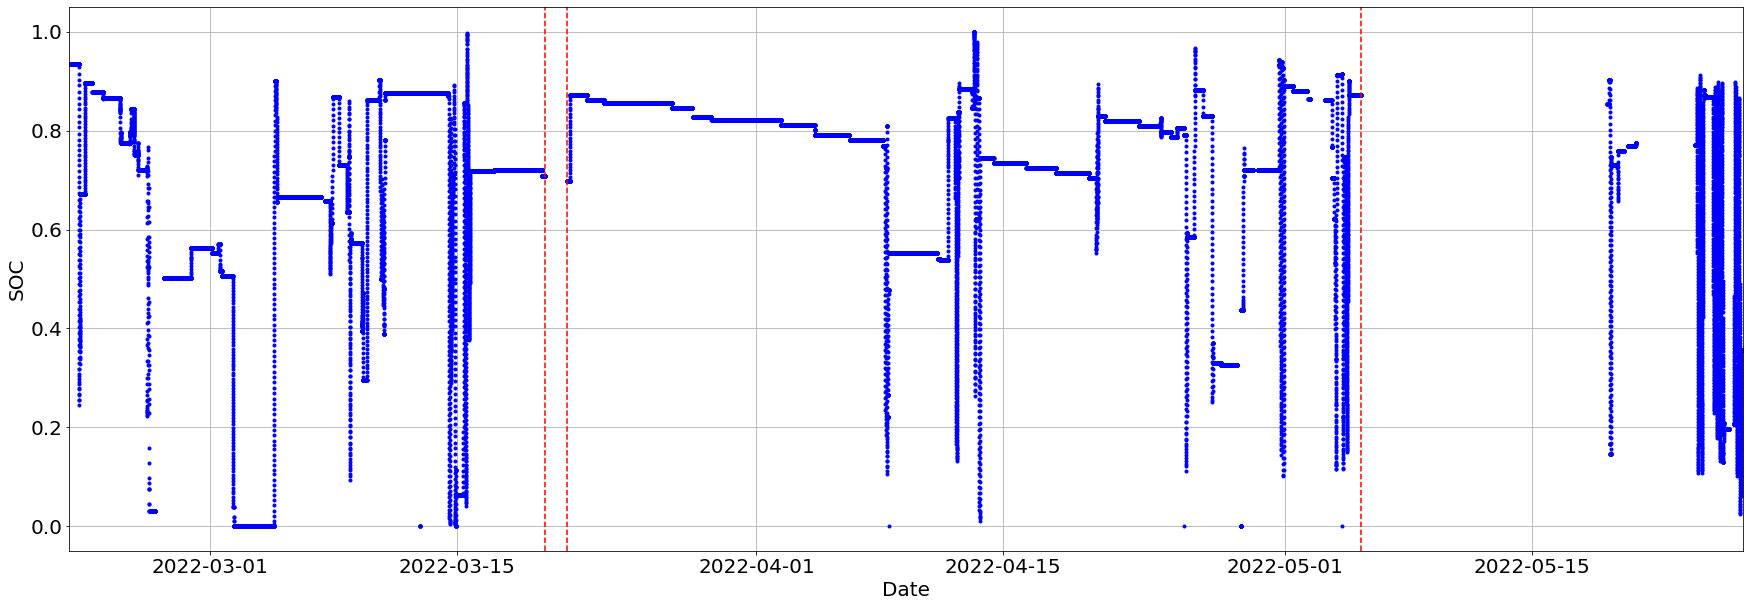

In [469]:
plt.figure(figsize=(30, 10))
plt.plot(df.index, df['SOC'],'b.')
plt.ylabel('SOC',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.xlim(df.index[0], df.index[-1])

plt.axvline(df.index[df.index == df_reduced.index[-1]], color='red', linestyle='--')
plt.axvline(df.index[idx_missing_rows_more_than_1_day[0]], color='red', linestyle='--')
plt.axvline(df.index[df.index == df.iloc[0:idx_missing_rows_more_than_1_day[0],:].tail().index[-1]], color='red', linestyle='--')
plt.show

### Create a column that will mark whether the data are original or inferred.

In [470]:
df_start = df_reduced.index[0]
df_end = df_reduced.index[len(df_reduced.index)-1]

time_range = pd.date_range(start=df_start, end=df_end, freq='min')
new_table = pd.DataFrame(index=time_range)


df_reduced[['HVAC Battery part Circulation Fan V1', 'HVAC Battery part heating','HVAC Battery part cooling']] = df_reduced[['HVAC Battery part Circulation Fan V1', 'HVAC Battery part heating','HVAC Battery part cooling']].astype(bool)
df_reduced["DataType"] = "real"

aligned_table = df_reduced.reindex(time_range)
aligned_table.loc[:, 'DataType'] = aligned_table.loc[:, 'DataType'].fillna("inferred")
df_extended = aligned_table.iloc[0:len(aligned_table)-1]
df_extended.tail()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-470-a0f28a9d7bfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["DataType"] = "real"


,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,DataType
2022-05-05 06:56:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:57:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:58:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:59:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 07:00:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real


## Use API to acquire missing outside temperature(at Liptovsky Hradok)

#### Plot original (denormalized) outside temperature 

<function matplotlib.pyplot.show(*args, **kw)>

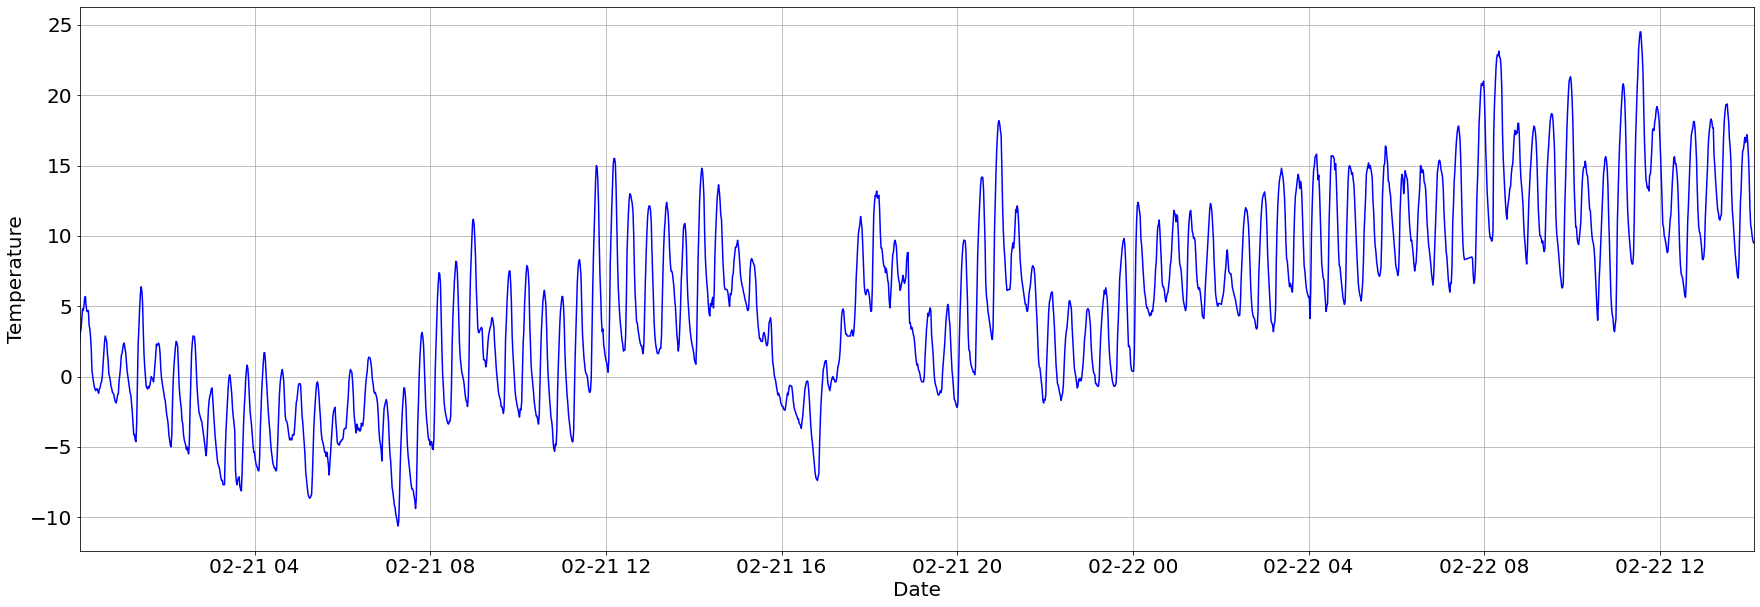

In [471]:
def denormalize(normalized_temp, original_min, original_max):
    original_temp = (normalized_temp * (original_max - original_min)) + original_min
    return original_temp
    
original_min = -15
original_max = 50
original_temp = denormalize(df_reduced['Outside Temperature'].values, original_min, original_max)

plt.figure(figsize=(30, 10))
#plt.plot(df_reduced.index, df_reduced['Outside Temperature'],'b')
plt.plot(df_reduced.index, original_temp,'b')
plt.ylabel('Temperature',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.xlim(df_reduced.index[0], df_reduced['Outside Temperature'].last_valid_index())
plt.show


#### Get API temperature data from Liptovsky Hradok

In [472]:
# The latitude and longitude of the location for which you want to retrieve historical weather data
latitude = 49.04
longitude = 19.72

# The start and end date for which you want to retrieve historical weather data
start_date = '2022-02-21'
end_date = '2022-05-05'

# Make a request to the OpenMeteo API
url = f'https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m'
response = requests.get(url)
weather_data = response.json()
time = weather_data['hourly']['time']
temperature = weather_data['hourly']['temperature_2m']



#### Normalize the range of temperatures into range from 0 to 1 (consider original range of -15" to 50").

In [473]:
min_temp = -15
max_temp = 50
normalized_temperature = [(temp - min_temp) / (max_temp - min_temp) for temp in temperature]


#### Plot the original hourly data from API with resampled minutely data

<function matplotlib.pyplot.show(*args, **kw)>

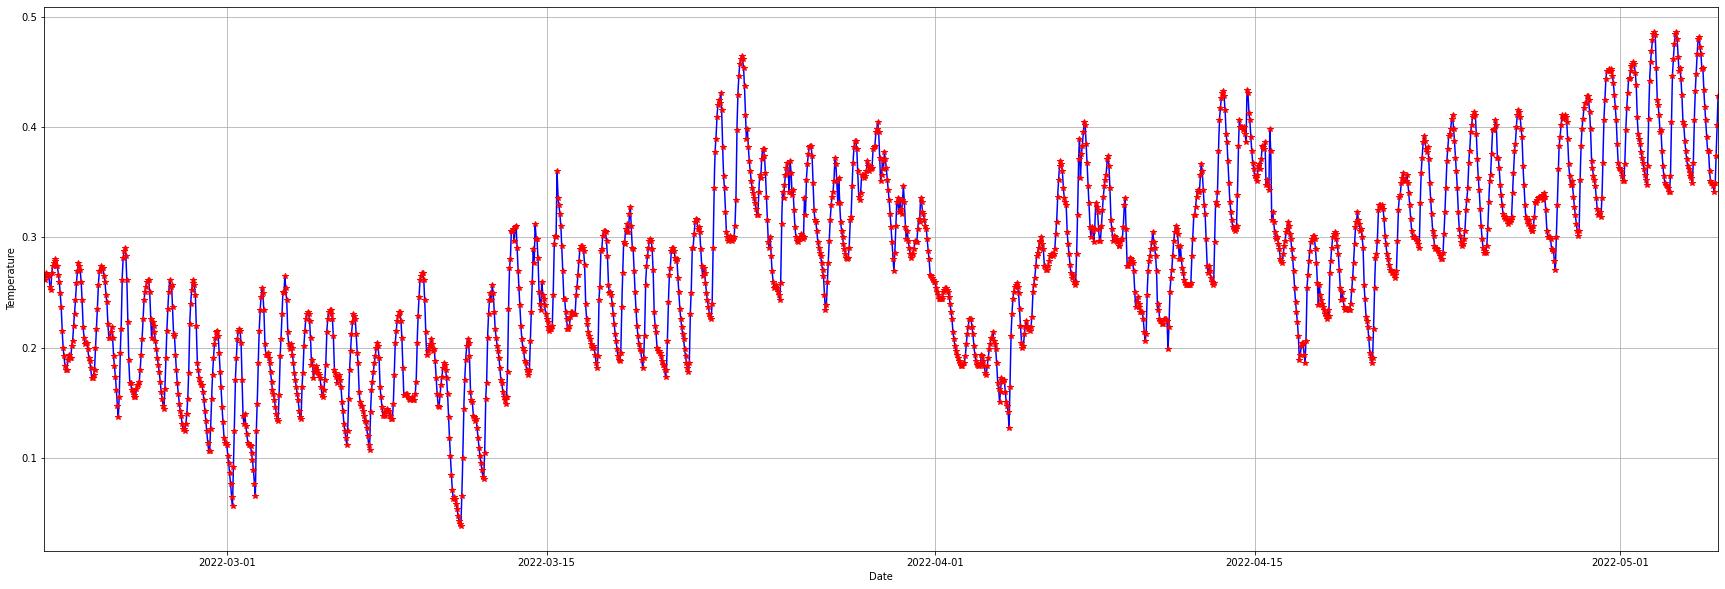

In [474]:
data = {'time': time, 'temperature': normalized_temperature}
df_hourly = pd.DataFrame(data)
df_hourly = df_hourly.iloc[0:len(df_hourly)-16]
datetime_list = [datetime.datetime.strptime(i, '%Y-%m-%dT%H:%M').strftime('%Y-%m-%d %H:%M:%S+00:00') for i in df_hourly['time']]
df_hourly['time'] = datetime_list
df_hourly['time'] = pd.to_datetime(df_hourly['time'])
df_hourly.set_index('time', inplace=True)

df_minutely = df_hourly.resample('T').interpolate()

plt.figure(figsize=(30, 10))
plt.plot(df_minutely.index, df_minutely['temperature'],'b')
plt.plot(df_hourly.index, df_hourly['temperature'],'r*')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df_minutely.index[0], df_minutely.index[-1])
plt.show


#### Compare original outside temperature data with API data from Liptovsky hrádok

<function matplotlib.pyplot.show(*args, **kw)>

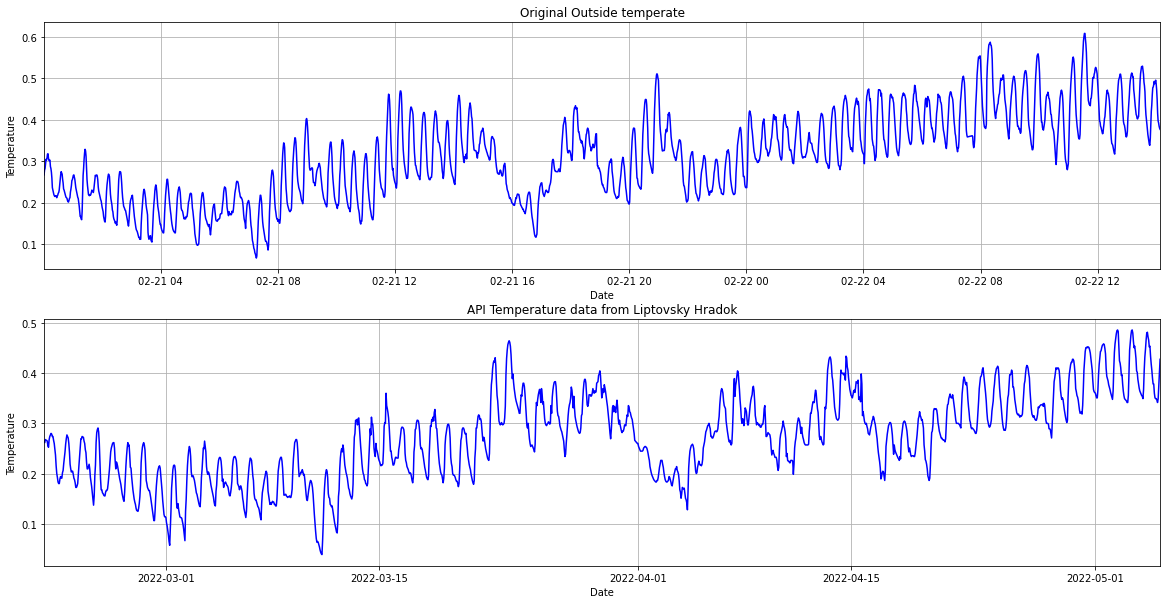

In [475]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(df.index, df['Outside Temperature'],'b')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('Original Outside temperate')
plt.grid()
plt.xlim(df.index[0], df['Outside Temperature'].last_valid_index())
plt.subplot(212)
plt.plot(df_hourly.index, df_hourly['temperature'],'b')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('API Temperature data from Liptovsky Hradok')
plt.grid()
plt.xlim(df_hourly.index[0], df_hourly.index[-1])
plt.show


#### Replace Outside Temperature with API resampled temperature data

In [476]:
df_extended['Outside Temperature'] = df_hourly['temperature'].resample('T').interpolate()


<ipython-input-476-3da27d01b199>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Outside Temperature'] = df_hourly['temperature'].resample('T').interpolate()


#### Interpolate numeric values and fill binary values by propagating the last valid observation forward

In [477]:
# Create a list of numeric columns and binary columns
numeric_cols = ['Active Power Setpoint', 'SOC', 'Battery part Fan Vb1 Feedback', 'Avg. Cell Temperature',
       'Max. Cell Temperatue', 'Min. Cell Temperature', 'String Power',
       'Outside Temperature', 'Ambient Temperature']
binary_cols = ['HVAC Battery part Circulation Fan V1',
       'HVAC Battery part heating', 'HVAC Battery part cooling',]
       
df_filled = df_extended
df_filled[numeric_cols] = df_filled[numeric_cols].interpolate()
df_filled = df_filled.ffill()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### VI. Split charging and discharging to separate columns (both real and desired);

In [478]:
df_filled['Desired Charging'] = np.where((df_filled['Active Power Setpoint'] <= 1) & (df_filled['Active Power Setpoint'] > 0) , df_filled['Active Power Setpoint'], 0)
df_filled['Desired Discharging'] =abs(np.where((df_filled['Active Power Setpoint'] < 0) & (df_filled['Active Power Setpoint'] > -1) , df_filled['Active Power Setpoint'], 0))

df_filled['Real Charging'] = np.where((df_filled['String Power'] <= 1) & (df_filled['String Power'] > 0) , df_filled['String Power'], 0)
df_filled['Real Discharging'] =  abs(np.where((df_filled['String Power'] < 0) & (df_filled['String Power'] > -1) , df_filled['String Power'], 0))

df_filled.head()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,DataType,Desired Charging,Desired Discharging,Real Charging,Real Discharging
2022-02-21 00:01:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263051,0.638462,real,0.0,0.0,0.0,0.0
2022-02-21 00:02:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263026,0.638462,real,0.0,0.0,0.0,0.0
2022-02-21 00:03:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.632212,0.595433,0.0,0.263000,0.637019,real,0.0,0.0,0.0,0.0
2022-02-21 00:04:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.595433,0.0,0.262974,0.635337,real,0.0,0.0,0.0,0.0
2022-02-21 00:05:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.596875,0.0,0.262949,0.635337,real,0.0,0.0,0.0,0.0


### VII. Aggregate data to the daily sum of binary values and daily mean of numeric.

In [479]:
binary_columns = [col for col in df_filled.columns if df_filled[col].dtype == 'bool']
integer_columns = [col for col in df_filled.columns if df_filled[col].dtype == 'float64']
agg_dict = {col:'sum' for col in binary_columns}
agg_dict.update({col:'mean' for col in integer_columns})

aggregated = df_filled.groupby(pd.Grouper(freq='D')).agg(agg_dict)
aggregated.head()

,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Active Power Setpoint,SOC,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,Desired Charging,Desired Discharging,Real Charging,Real Discharging
2022-02-21 00:00:00+00:00,272,0,272,0.002613,0.822302,0.0,0.630471,0.652583,0.602331,-0.001100,0.248480,0.637805,0.045490,0.042182,0.038978,0.040078
2022-02-22 00:00:00+00:00,92,0,92,-0.000556,0.883031,0.0,0.630514,0.645578,0.610537,-0.000808,0.222145,0.595088,0.000278,0.000833,0.000000,0.000808
2022-02-23 00:00:00+00:00,126,0,126,-0.001875,0.857874,0.0,0.628165,0.643575,0.605255,-0.004503,0.226339,0.593035,0.003611,0.005486,0.002047,0.006550
2022-02-24 00:00:00+00:00,65,0,65,-0.003660,0.780013,0.0,0.643514,0.658597,0.625185,-0.005222,0.199730,0.589158,0.009005,0.012664,0.006934,0.012156
2022-02-25 00:00:00+00:00,247,0,247,-0.032743,0.378751,0.0,0.641009,0.663571,0.618350,-0.034684,0.213035,0.632962,0.036389,0.069132,0.030332,0.065017


# LOAD

## VIII. Find a reasonable way to render how much we charge and discharge BESS daily

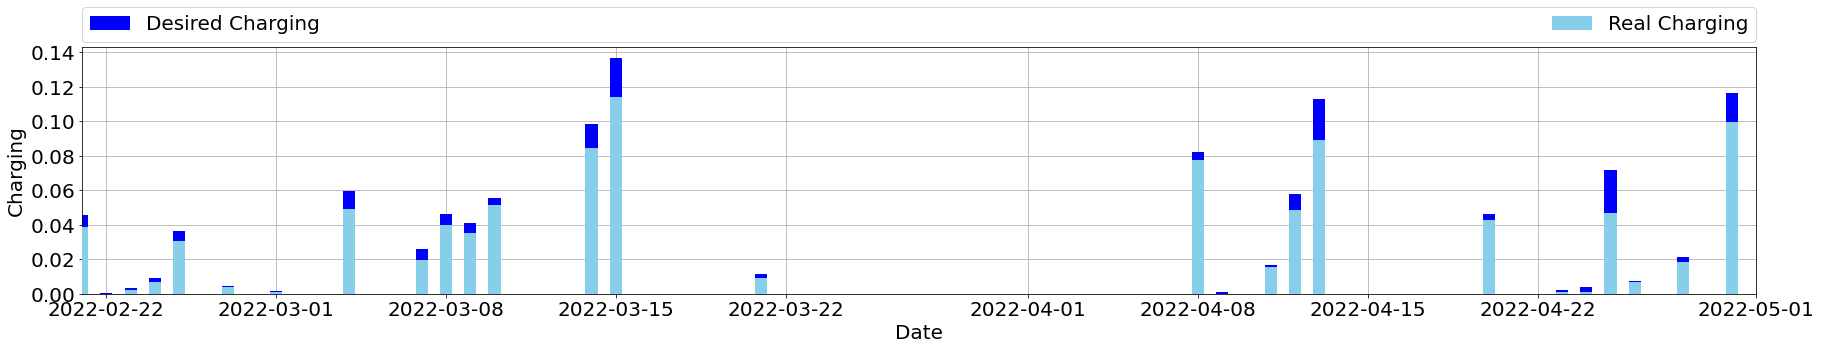

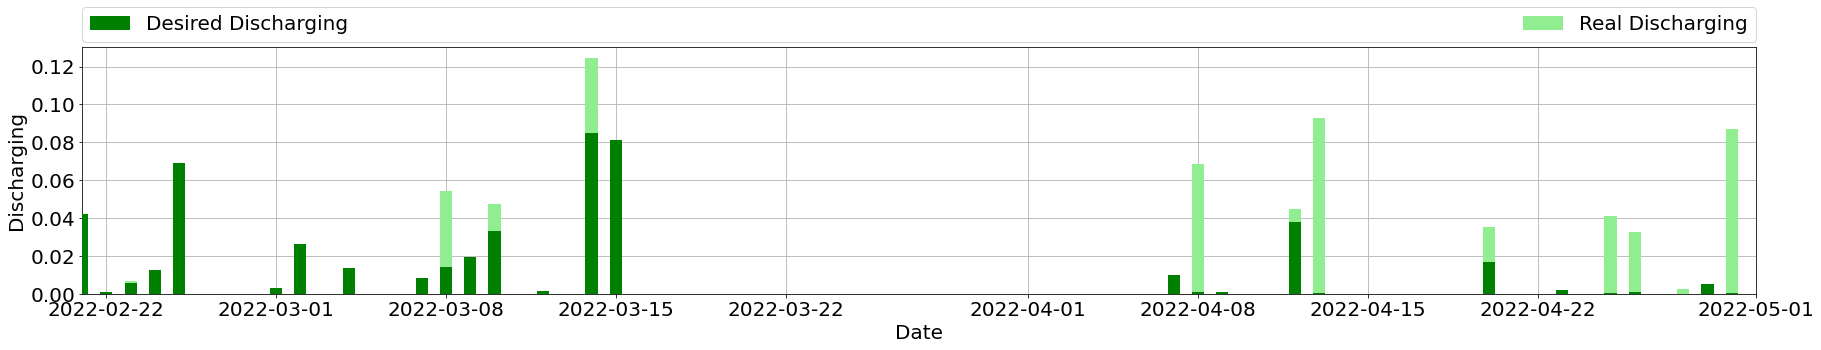

In [480]:
start_time = pd.Timestamp('2022-02-21 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-05-01 00:00:00+0000', tz='UTC')

times = list(aggregated.index)
values_char = list(aggregated['Real Charging'])
values_dis = list(aggregated['Real Discharging'])
val_char = list(aggregated['Desired Charging'])
val_dis = list(aggregated['Desired Discharging'])
val_SOC = list(aggregated['SOC'])

plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.grid(zorder=0)
plt.bar(times, val_char,  width=0.5, align='center', color='blue', zorder=2)
plt.bar(times, values_char,  width=0.5, align='center', color='skyblue', zorder=3)
plt.ylabel('Charging', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(start_time, end_time)
plt.legend(['Desired Charging', 'Real Charging'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)

plt.figure(figsize=(30, 10))
plt.subplot(212)
plt.grid(zorder=0)
plt.bar(times, val_dis, width=0.5, align='center', color='green', zorder=4)
plt.bar(times, values_dis, width=0.5, align='center', color='lightgreen', zorder=3)
plt.ylabel('Discharging', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(start_time, end_time)
plt.legend(['Desired Discharging', 'Real Discharging'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)

## IX. Find a reasonable way to render weekly seasonality in data;


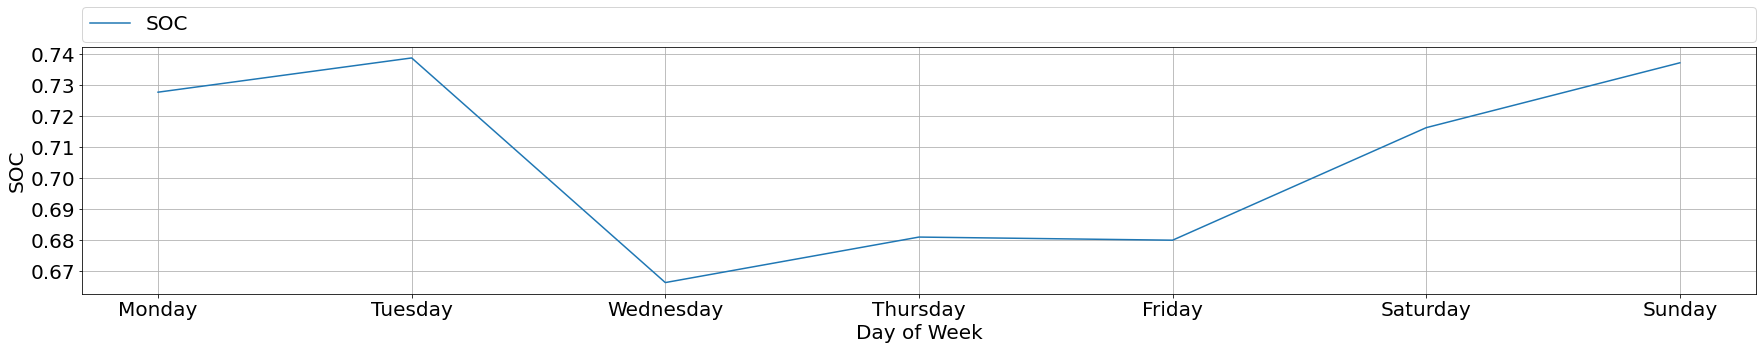

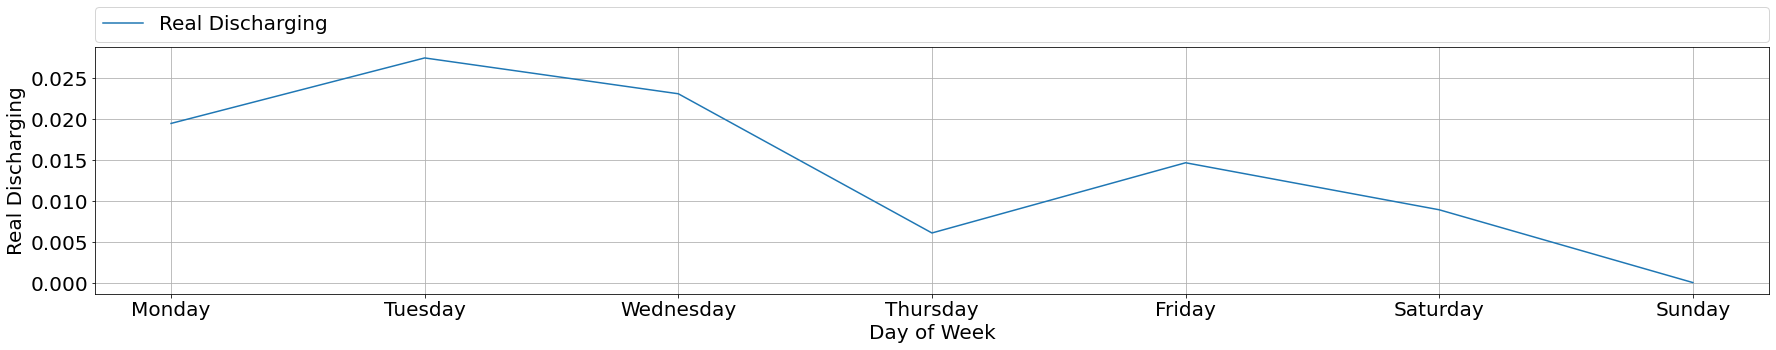

In [481]:
# Add a column for the day of the week
data = df_filled
# Add a column for the day of the week
data['day_of_week'] = data.index.dayofweek

# Create a dictionary to map the numerical values to the day names
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

# Use the map method to replace the numerical values with the day names
data['day_of_week'] = data['day_of_week'].map(day_names)

# Group data by day of the week and calculate the mean
weekday_mean = data.groupby('day_of_week').mean()

# Reorder the index of the weekday_mean dataframe
weekday_mean = weekday_mean.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the mean values by day of the week
plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.plot(weekday_mean.index, weekday_mean['SOC'])
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('SOC', fontsize=20)
plt.grid()
plt.legend(['SOC'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.figure(figsize=(30, 10))
plt.subplot(212)
plt.plot(weekday_mean.index, weekday_mean['Real Discharging'])
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('Real Discharging', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(['Real Discharging'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.show()

## X. Identify the error in the HVAC command realization when sending the binary command that did not change HVAC's state;


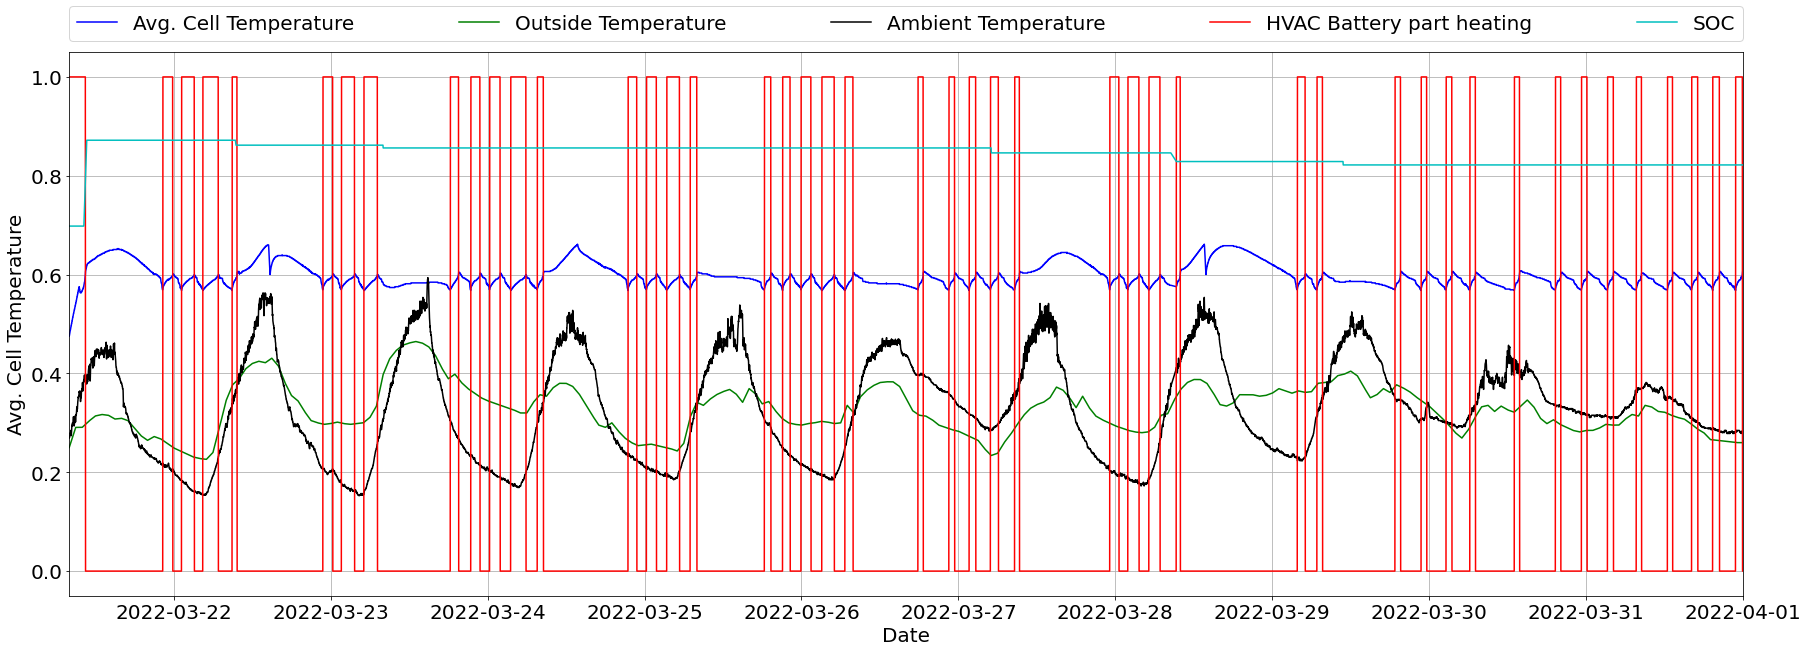

In [482]:
start_time = pd.Timestamp('2022-03-21 08:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.ylabel('Avg. Cell Temperature',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.xlim(start_time, end_time )
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')
plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['HVAC Battery part heating'][mask],'r')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'c')
plt.plot()

plt.legend(['Avg. Cell Temperature', 'Outside Temperature', 'Ambient Temperature', 'HVAC Battery part heating', 'SOC'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)

plt.show()

## XI. Plot change-points in the data (due to anomaly or drift)

### Plot change points (red squares)

<function matplotlib.pyplot.show(*args, **kw)>

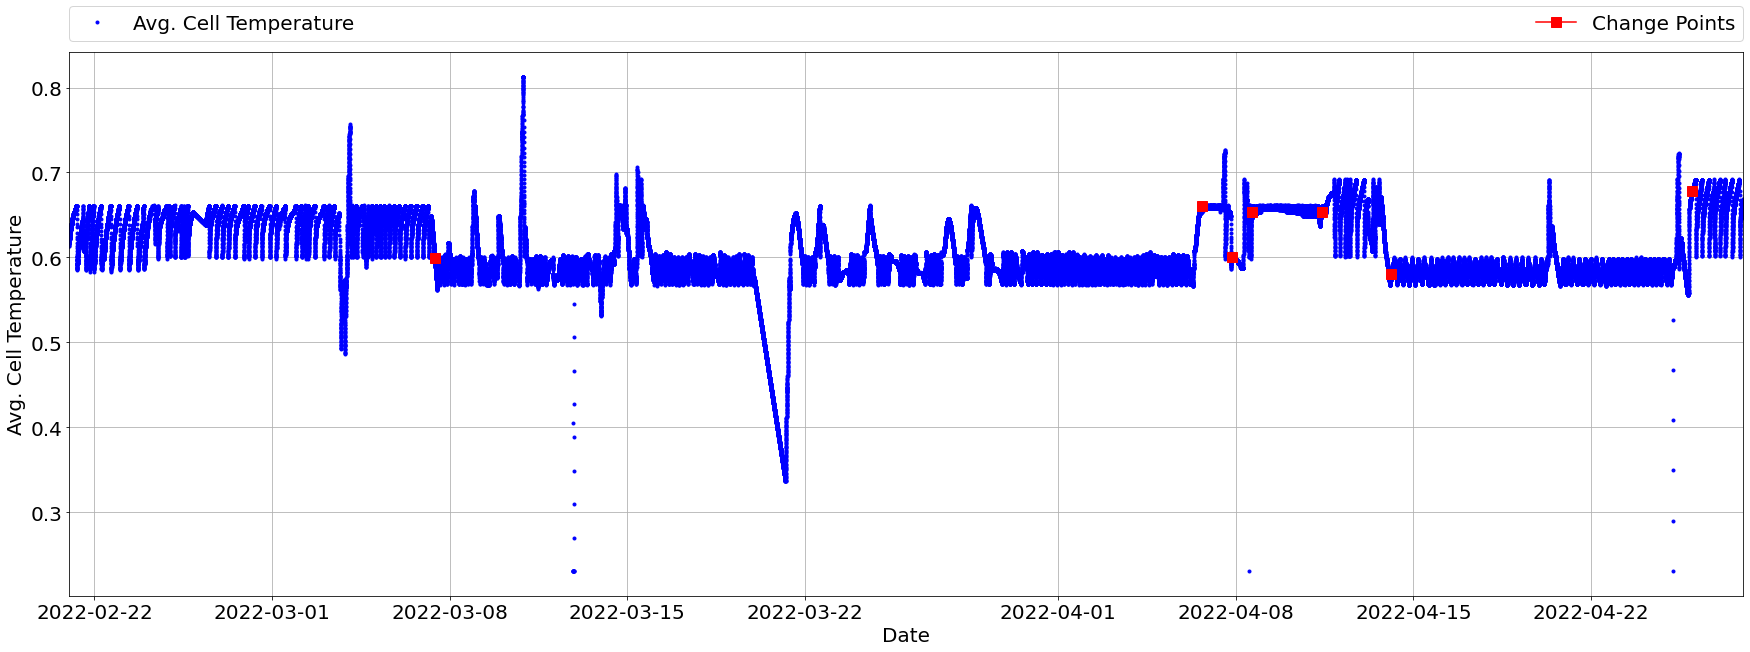

In [483]:
start_time = pd.Timestamp('2022-02-21 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-28 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b.')




#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
#plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')

idx1 = (df_filled.index == pd.Timestamp('2022-03-07 10:00:00+0000', tz='UTC'))
idx2 = (df_filled.index == pd.Timestamp('2022-04-07 20:00:00+0000', tz='UTC'))
idx3 = (df_filled.index == pd.Timestamp('2022-04-08 15:30:00+0000', tz='UTC'))
idx4 = (df_filled.index == pd.Timestamp('2022-04-11 10:00:00+0000', tz='UTC'))
idx5 = (df_filled.index == pd.Timestamp('2022-04-26 00:00:00+0000', tz='UTC'))
idx6 = (df_filled.index == pd.Timestamp('2022-04-06 16:00:00+0000', tz='UTC'))
idx7 = (df_filled.index == pd.Timestamp('2022-04-14 03:00:00+0000', tz='UTC'))

plt.plot(df_filled.index[idx1], df_filled['Avg. Cell Temperature'][idx1], color='red',marker='s',markersize=10)
plt.plot(df_filled.index[idx2], df_filled['Avg. Cell Temperature'][idx2],color='red',marker='s',markersize=10)
plt.plot(df_filled.index[idx3], df_filled['Avg. Cell Temperature'][idx3],color='red',marker='s',markersize=10)
plt.plot(df_filled.index[idx4], df_filled['Avg. Cell Temperature'][idx4],color='red',marker='s',markersize=10)
plt.plot(df_filled.index[idx5], df_filled['Avg. Cell Temperature'][idx5],color='red',marker='s',markersize=10)
plt.plot(df_filled.index[idx6], df_filled['Avg. Cell Temperature'][idx6],color='red',marker='s',markersize=10)

plt.plot(df_filled.index[idx7], df_filled['Avg. Cell Temperature'][idx7],color='red',marker='s',markersize=10)
plt.legend(['Avg. Cell Temperature', 'Change Points'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.ylabel('Avg. Cell Temperature',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(start_time, end_time) 

plt.show

### Plot the temperature of the battery and ambient/outside temperature

<function matplotlib.pyplot.show(*args, **kw)>

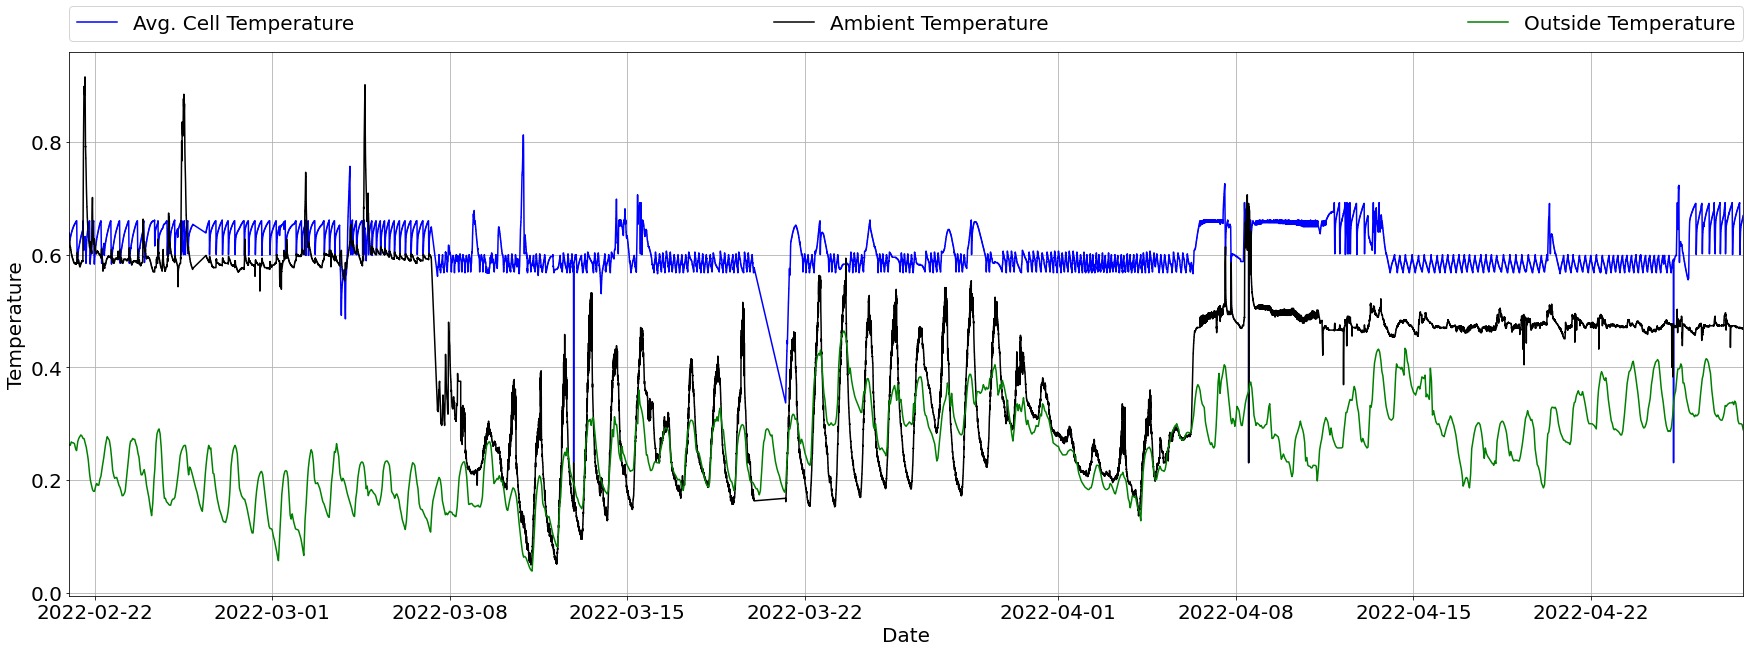

In [484]:
start_time = pd.Timestamp('2022-02-21 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-28 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')


plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')

plt.ylabel('Temperature',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.xlim(start_time, end_time) 
plt.legend(['Avg. Cell Temperature', 'Ambient Temperature', 'Outside Temperature',], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.show

### Plot temperature with real and inferred data

<function matplotlib.pyplot.show(*args, **kw)>

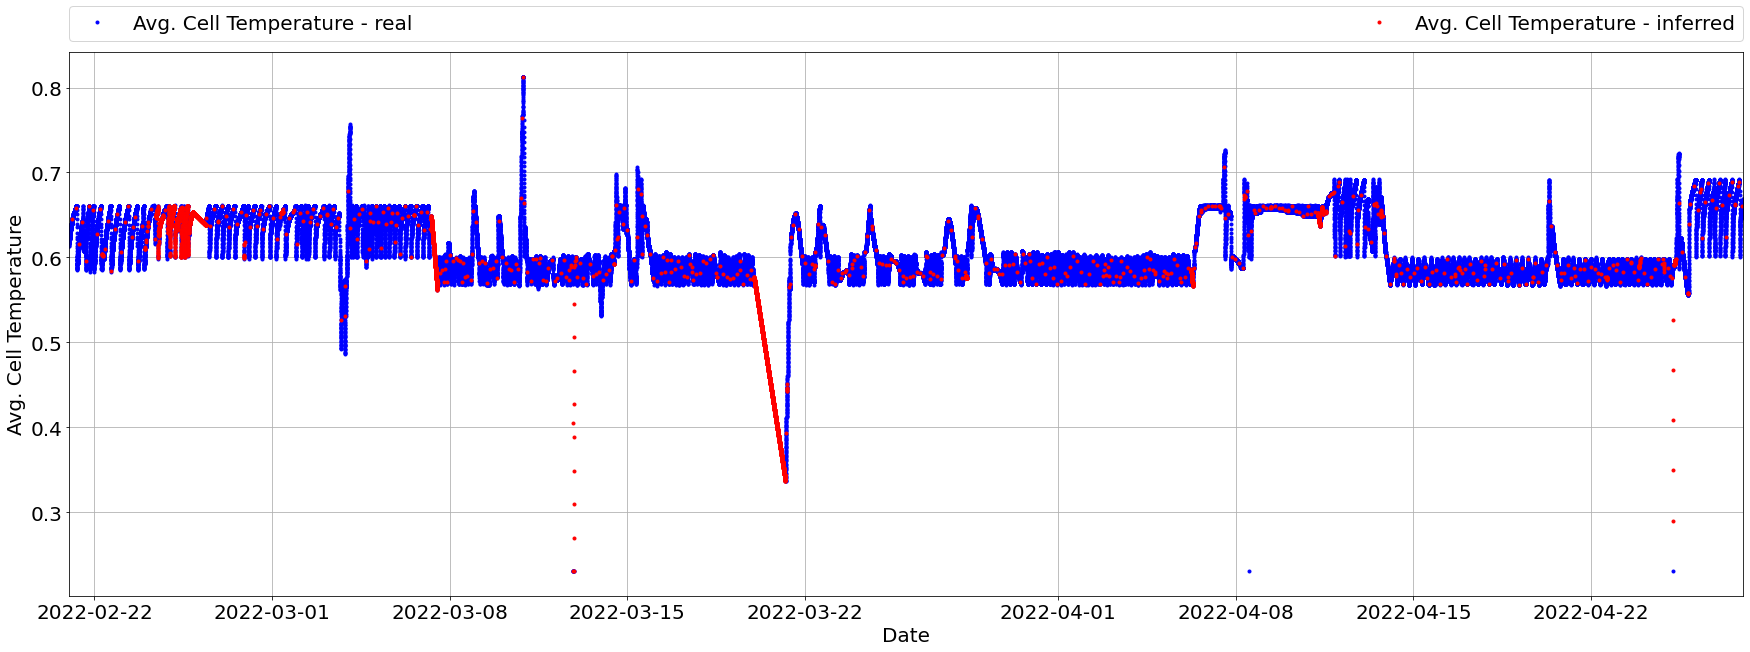

In [485]:
start_time = pd.Timestamp('2022-02-21 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-28 00:01:00+0000', tz='UTC')

real_data = (df_filled['DataType'] == 'real')
inferred_data = (df_filled['DataType'] == 'inferred') 

plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[real_data], df_filled['Avg. Cell Temperature'][real_data],'b.')
plt.plot(df_filled.index[inferred_data], df_filled['Avg. Cell Temperature'][inferred_data],'r.')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Avg. Cell Temperature',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.grid()
plt.xlim(start_time, end_time) 
plt.legend(['Avg. Cell Temperature - real', 'Avg. Cell Temperature - inferred'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.show

## XII. Identify meaningful points where set point and real string power deviate

(738274.7506944444, 738276.0006944444)

<Figure size 2160x720 with 0 Axes>

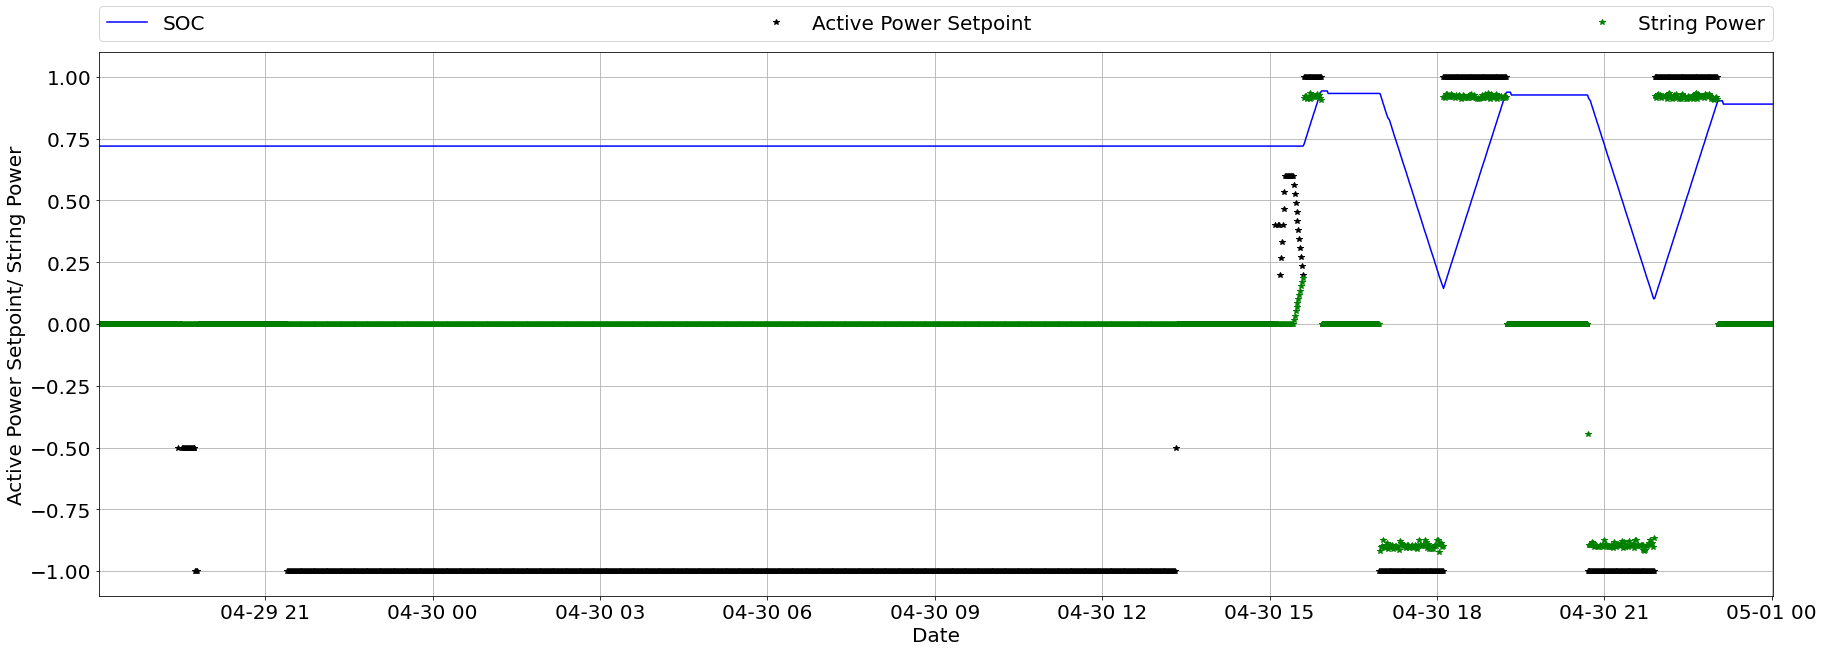

In [486]:
real_data = (df_filled['DataType'] == 'real')
inferred_data = (df_filled['DataType'] == 'inferred') 
max_sp = pd.Timestamp('2022-04-30 15:10:00+0000', tz='UTC')

plt.figure(figsize=(30, 10))
start_time = pd.Timestamp('2022-04-29 18:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-05-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'b')

plt.plot(df_filled.index[mask], df_filled['Active Power Setpoint'][mask],'k*')
#plt.plot(df_filled.index[inferred_data], df_filled['Active Power Setpoint'][inferred_data],'r*')
plt.plot(df_filled.index[mask], df_filled['String Power'][mask],'g*')


plt.ylabel('Active Power Setpoint/ String Power', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

plt.legend(['SOC', 'Active Power Setpoint', 'String Power'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)

plt.xlim(start_time, end_time)

## XIII. Discuss rare high SOC events;

(738215.0006944444, 738271.0006944444)

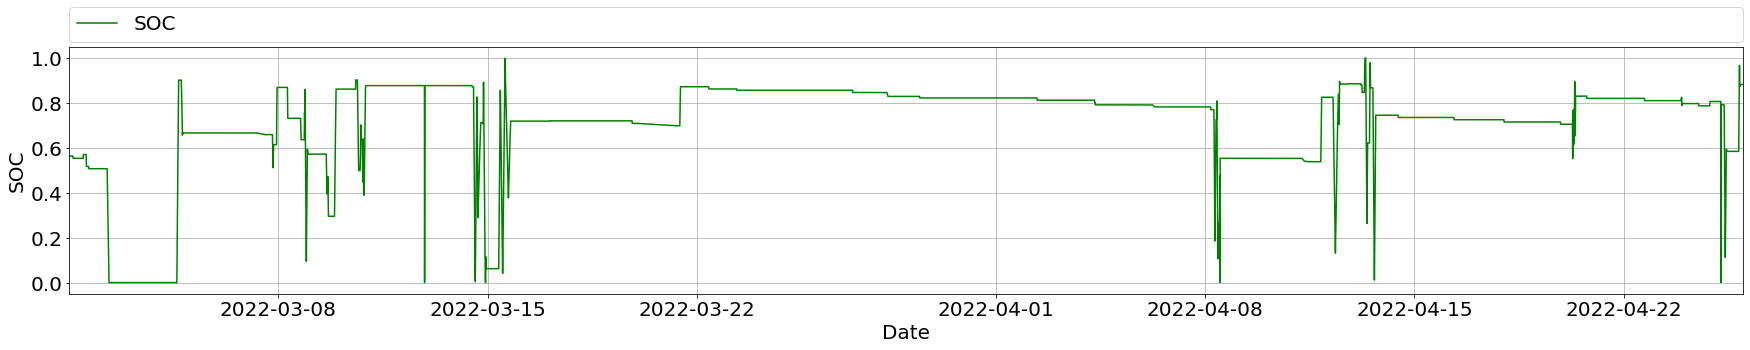

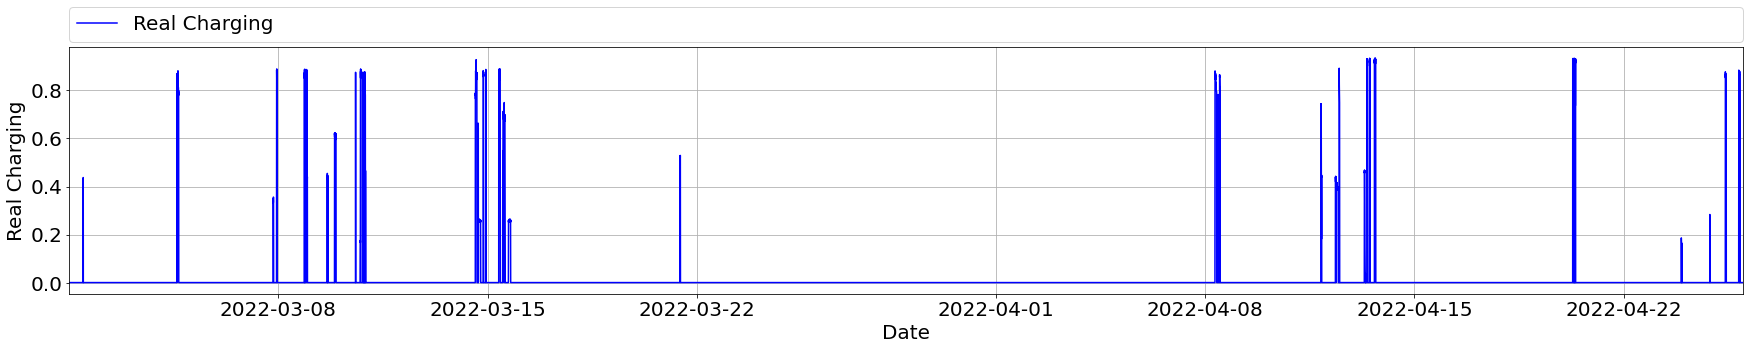

In [487]:
start_time = pd.Timestamp('2022-03-01 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-26 00:01:00+0000', tz='UTC')

real_data = (df_filled['DataType'] == 'real')
inferred_data = (df_filled['DataType'] == 'inferred')

plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.plot(df_filled.index, df_filled['SOC'],'g')
plt.xlabel('Date',fontsize=20)
plt.ylabel('SOC',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(['SOC'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.xlim(start_time, end_time )

plt.figure(figsize=(30, 10))
plt.subplot(212)
plt.plot(df_filled.index, df_filled['Real Charging'],'b')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Real Charging',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(['Real Charging'], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5, fontsize=20)
plt.xlim(start_time, end_time )

## XIV. Save annotated data to a CSV file.

In [488]:
df_filled.to_csv('BESS.csv', index=True)